# Test the code on Target data
March 24th

## Parsing

In [14]:
import pandas as pd
import numpy as np
import os

import pdftotext
import re
from itertools import chain

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA


def is_FactSet(filepath):
    check_words = ["Corrected Transcript",
                  "www.callstreet.com",
                  "FactSet CallStreet, LLC"]
    pdfFileObj = open(filepath,'rb')
    pdf = pdftotext.PDF(pdfFileObj)
    text = "\n\n".join(pdf)
    if all([ check_word in text for check_word in check_words]):
        return("FactSet")
    else:
        return("plain")
    


def get_fp_cp(fp):
    # fp means front page: from first page to Corporate Participants
    # get names of Corporate Participants
    output = list()
    for item in fp[fp.index("CORPORATE PARTICIPANTS"):]:
        if "Walmart" in item:
            for x in item.split("."):
                output = output + x.split(",")
            for x in item.split("-"):
                output = output + x.split("   ")
            for x in item.split("-"):
                output = output + x.split(".")
            for x in item.split("   "):
                output = output + x.split(",")
        else: 
            output = output + item.split()
    return([item.strip() for item in output if len(item) > 1]) 



def parse_FactSet_para(filepath, filename):
    """ return a dataframe, each row is a paragraph spoken by one person
    # columns include (1)paragraph and (2)date
    """ 
    pdfFileObj = open(filepath,'rb')
    pdf = pdftotext.PDF(pdfFileObj)
    text = "\n\n".join(pdf)

    tmp = text.split("........................................\
..............................................................\
..............................................................\
..................................................................................")

    # process words appeared in the front page and CORPORATE PARTICIPANTS section
    # fp means front page: from first page to Corporate Participants
    # fp contains a lot of info that repeat in the file
    fp = [item.strip() for item in tmp[0].split("\r\n") if len(item)>=1]

    # 
    to_be_removed = [fp[0], fp[1], fp[3]] + \
                    fp[2].split() + \
                    [x for x in fp[5].split(" ") if len(x) >= 1]

    # sort words to be removed by len to prevent missing to remove longer words
    to_be_removed_df = pd.DataFrame(set(to_be_removed))
    to_be_removed_df["len"] = to_be_removed_df[0].map(lambda x: len(x))
    to_be_removed_df = to_be_removed_df.sort_values(["len"], ascending = False)

    # remove words from fp
    for item in to_be_removed_df[0]:
        for i in range(1, len(tmp)):
            tmp[i] = tmp[i].replace(item, '')

    # remove "\r\n"
    for i in range(1, len(tmp)):
        tmp[i] = tmp[i].replace("\r\n", ' ').lstrip(", ")

    # 
    tmp = pd.DataFrame(tmp[2:], columns=["paragraph"])
    
    # add date
    tmp["date"] = pd.to_datetime(filename[:8])

    return(tmp)


def parse_plain_para(filepath, filename):
    """ return a dataframe, each row is a paragraph spoken by one person
    # columns include (1)paragraph and (2)date
    """ 
    pdfFileObj = open(filepath,'rb')
    pdf = pdftotext.PDF(pdfFileObj)
    # combine pages
    text = "\n\n".join(pdf)
    # locate "\r\n" to locate starts of paragraphs later
    text = re.sub("\r\n", " WRAPTEXT ",text)

    # remove unuseful terms
    ##### if got time, revise this part bc it takes too long
    to_remove = [" THOMSON REUTERS STREETEVENTS", " ©2018 Thomson", 
              " Client Id", '\uf0b7', " ©2017 Thomson", " ©2016 Thomson",
               "WAL-MART STORES, INC. COMPANY CONFERENCE PRESENTATION",
                "WAL-MART STORES INC. COMPANY CONFERENCE PRESENTATION ",
                "Thomson Reuters", "Investment Community "]
    for item in to_remove:
        text = re.sub(item, " ",text)

    # tokenize and tag POS
    tokens = nltk.word_tokenize(text)
    pos = nltk.pos_tag(tokens)

    # locate starts of paragraphs
    locate = list()
    for i in range(len(pos)-2):
        punctuation = ["•", "’"]
        if pos[i][0] == "WRAPTEXT" and pos[i+1][1] == "NNP" and pos[i+1][0] != "•" and pos[i+2][1] == "NNP"\
        and pos[i+2][0] not in punctuation:
            locate.append((i, [pos[i+1], pos[i+2]]))
        elif pos[i][0] == "WRAPTEXT" and pos[i+1][1] == "NNP" and pos[i+1][0] not in punctuation and pos[i+2][0] == ":" :
            locate.append((i, [pos[i+1], pos[i+2]]))

    tmp = list()
    for i in range(0,len(locate)-1):
        start_loc = int(locate[i][0])
        end_loc = int(locate[i+1][0])
        para = tokens[start_loc:end_loc]
        tmp.append(" ".join(para))
        
    tmp = pd.DataFrame(tmp, columns=["paragraph"])
    tmp["date"] = pd.to_datetime(filename[:8])
    return(tmp)

def consolidate_files(years):
    """
        input is list of years
        output is df, columns include "filename", "filepath", "type"
    """
    files = pd.DataFrame()
    for year in years:
        path = os.getcwd() + '\Transcripts' + "\\" + str(year)
        # get file names
        tmp = pd.DataFrame(os.listdir(path), columns=["filename"])
        # get file path for each file
        tmp["filepath"] = tmp["filename"].map(lambda x: path + "\\" + x)
        # check if it's a fancy(FACTSET) file
        tmp["type"] = tmp["filename"].map(lambda x: is_FactSet(path + "\\" + x))
        files = pd.concat([files, tmp])
        
    files = files.reset_index(drop=True)
    return(files)

def consolidate_files_others(company):
    """
        input is the name of company, the name of folder
        output is df, columns include "filename", "filepath", "type"
    """
    # get path
    path = os.getcwd() + '\Transcripts Scraping' + "\\" + company
    # get file names
    tmp = pd.DataFrame(os.listdir(path), columns=["filename"])
    # get file path for each file
    tmp["filepath"] = tmp["filename"].map(lambda x: path + "\\" + x)
    # check if it's a fancy(FACTSET) file
    tmp["type"] = tmp["filename"].map(lambda x: is_FactSet(path + "\\" + x))     

    return(tmp)


def filenames_to_para(files):
    """
        input is df, columns include "filename", "filepath", "type"
        output is df, columns include paragraph and date
    """
    paragraphs = pd.DataFrame()
    for i in files.index:
        filepath = files.loc[i, "filepath"]
        filename = files.loc[i, "filename"]
        if files.loc[i, "type"] == "plain":
            paragraphs = pd.concat([paragraphs, parse_plain_para(filepath, filename)], ignore_index=True)
        elif files.loc[i, "type"] == "FactSet":
            paragraphs = pd.concat([paragraphs, parse_FactSet_para(filepath, filename)], ignore_index=True)
    return(paragraphs)



def get_unique_words(para_tokens):
    """
    input is a pd.Series of lists of POS-tagged words
    """
    all_tokens = list(chain.from_iterable(para_tokens))
    all_tokens = pd.Series(all_tokens)
    tokens_count = all_tokens.value_counts()
    return(tokens_count)

    

# collect all tagged tokens
def get_all_wordsPos(token_pos, duplicate=False):
    all_tokens = pd.Series(chain.from_iterable(token_pos))
    if duplicate == True:
        all_tokens = all_tokens.drop_duplicates()
    d = {"word": all_tokens.map(lambda x: x[0]),
         "pos": all_tokens.map(lambda x: x[1])}
    return(pd.DataFrame(d))



# this is for wordnet lemmatizer to recognize POS
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''



# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\harit\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [15]:
import pandas as pd
import os
#from transcript_functions import *
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
%matplotlib inline  

In [18]:
files = consolidate_files_others('Costco2')

In [19]:
%%time
# parse into paragraphs
df = filenames_to_para(files)

Wall time: 16.4 s


## Preprocessing

In [20]:
%%time
df["tokens"] = df["paragraph"].map(nltk.word_tokenize)

# tag Part of Speech
df["tokens_pos"] = df["tokens"].map(nltk.pos_tag)

## to check distribution of POS tags
# df_all_tokens = get_all_wordsPos(df["tokens_pos"])

# filter words with pos not in pos_remaining
pos_remaining = ["NN", "NNS", 
                 "VB", "VBD", "VBN", "VBP", "VBZ"
                ] # take out "JJ", "JJR", "JJS"
df["tokens_pos"] = df["tokens_pos"].map(lambda x: [tup for tup in x if tup[1] in pos_remaining])

# lemmatize with POS
lemmatizer = WordNetLemmatizer()
df["tokens_clean"] = df["tokens_pos"].map(lambda x: [lemmatizer.lemmatize(tup[0], get_wordnet_pos(tup[1])) for tup in x ])

# remove rows that have no content after lemmatization
df = df[df["tokens_clean"].map(lambda x: len(x)>=1)]

# remove punctuation
punctuation = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in punctuation])

# remove stop words
stop_words = set(stopwords.words('english'))
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove some specific cases
others = ["'s", "'re", "'ve", "n't", "'ll", "–", "'m"]
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in others])

# lower case
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word.lower() for word in x])

df = df[df["tokens_clean"].map(lambda x: len(x)>=1)]

# # remove short words
# df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if len(word)>3])

# # remove long words
# df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if len(word)<16])

Wall time: 15.8 s


In [21]:
# removing some words
removing_words = [
    "get", "think", "thing", "know", "kind", "way", "look", "year",
     "question", "guy", "thank", "quarter", "lot", "want", "herein",
    "talk", "guess", "see", "say", "make", "go", "store", "customer",
    "business", "time", "ph", "take", "bit", "work", "morning", 
    "company", "mean", "wraptext", "”", '’'
]
df["tokens_clean"] = df["tokens_clean"].map(lambda x: [word for word in x if word.lower() not in removing_words])

## filter out rows containing too few words/tokens
df["len_clean"] = df["tokens_clean"].map(len)
df = df[df["len_clean"]>10]

# removing disclaimer
df = df[df["paragraph"].map(lambda x: "The information in the transcripts" not in x)]
df = df[df["paragraph"].map(lambda x: "disclaimer" not in x.lower())]

In [22]:
# removing some paragraphs
removing_words = ["www.streetevents.com"]

mask = df["tokens_clean"].map(lambda x: removing_words[0] not in x)
df = df[mask]

# removing short paragraphs
df = df[df.len_clean > 22]

## Check omni's tag

In [ ]:
# df["tokens_pos"] = df["tokens"].map(nltk.pos_tag)
# tokens_pos = df["tokens_pos"]
# key_word = "omni"
# check = get_unique_words(tokens_pos)
# check = pd.DataFrame(check)
# check["pos"] = check.index
# check[check["pos"].map(lambda x: key_word in x[0])]

In [ ]:
# # look at unique words to get a sense what needs to be delete
# unique_words = get_unique_words(df["tokens_clean"])

## LDA

In [23]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [24]:
# prepare count vector as the input of LDA model
df["corpus"] = df["tokens_clean"].map(lambda x: ', '.join(x))
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(df["corpus"])

number_topics = 20

# fix random_state at 33
lda = LDA(n_components=number_topics, n_jobs=-1, random_state =33)
lda.fit(count_data)
       
number_words = 12
# print_topics(lda, count_vectorizer, number_words)

words = count_vectorizer.get_feature_names()

# print topics and key words
for topic in range(0,number_topics):
    topic_vec = lda.components_[topic]
    topic_idx = topic_vec.argsort()[:-10 - 1:-1]
    print("topic:", topic + 1, " ====================")
    for i in topic_idx:
        print('{:<10} {:>10.2%}'.format(words[i], topic_vec[i]/topic_vec.sum()))

topic: 1  ====================
price           1.91%
people          1.78%
item            1.56%
help            1.28%
millennials      1.28%
fact            1.13%
point           1.01%
value           1.00%
end             0.81%
come            0.81%
topic: 2  ====================
card            6.10%
member          2.74%
sign            2.04%
people          1.89%
credit          1.85%
transition      1.35%
increase        1.33%
term            1.31%
week            1.13%
use             1.06%
topic: 3  ====================
basis           5.31%
point           4.89%
gas             3.02%
report          2.59%
margin          1.91%
sale            1.83%
deflation       1.77%
term            1.66%
year            1.54%
income          1.45%
topic: 4  ====================
unit            2.56%
item            2.26%
vendor          2.14%
day             1.76%
change          1.59%
warehouse       1.45%
margin          1.34%
end             1.31%
size            1.29%
sale            1

## Visualize topic distribution

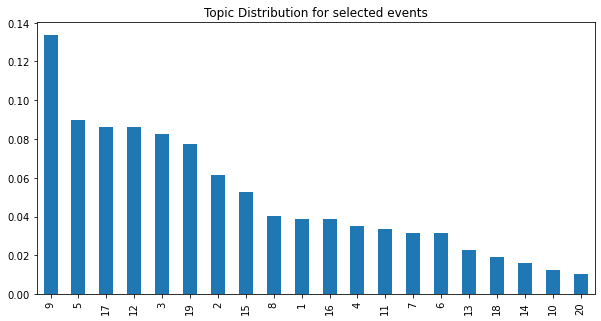

In [25]:
# assign topic to paragraphs
topic_match = lda.transform(count_data)
df["topic"] = [ x.argsort()[-1] + 1 for x in topic_match]

# # chech how many topics in each paragraphs
# df["number of topics"] = [sum(x>x.mean()) for x in topic_match]

topic_counts = df["topic"].value_counts()
(topic_counts/topic_counts.sum()).plot(x="Topics", y="percentage",
                                       title="Topic Distribution for selected events",
                                       kind="bar", figsize=(10,5))

## Visualize paragraph counts for each year

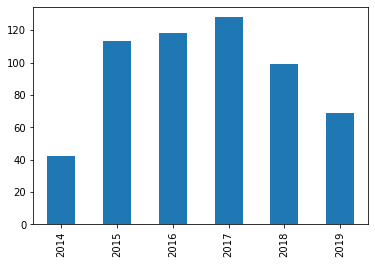

In [26]:
# df['quarter'] = pd.PeriodIndex(df.date, freq='Q')
df['year'] = pd.PeriodIndex(df.date, freq='Y')
df["year"].value_counts().sort_index().plot(kind='bar')

## Topic trends

In [27]:
tmp = pd.crosstab(test["year"], test["topic"], normalize="index")
years = [ str(x) for x in tmp.index]

NameError: name 'test' is not defined

In [28]:
for topic in tmp:
    fig, ax = plt.subplots()
    plt.plot(years, tmp[topic].values)
    plt.ylim(0, 0.4)
    plt.xticks(years, years, rotation='vertical')
    plt.title("topic "+ str(topic))

NameError: name 'tmp' is not defined

In [ ]:
check = test[test["topic"]==18]
check[check["year"] == 2017]["paragraph"].iloc[0].replace("WRAPTEXT", "")

In [ ]:
## search for certain key word
keyword = "shareholder"
check[check["paragraph"].map(lambda x: keyword in x)]

## Interactive visualization

In [ ]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared

## Visualize components for each year (stop using for now)

In [ ]:
# event_tp = df.groupby(by=["year","topic"])["topic"].count().unstack().fillna(0)
# tmp = event_tp.T.apply(sum)
# event_tp = event_tp.apply(lambda x: x/tmp)
# event_tp.index = [str(x)[:10] for x in event_tp.index]

# fig, ax = plt.subplots(figsize=(16, 5))
# colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 
#           'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# bottom = np.array([0]*event_tp.shape[0])
# x = event_tp.index.values

# for i in event_tp.columns:
# #     print(event_tp[i].values)
#     plt.bar(x, event_tp[i].values, width=0.5, color=colors[int(i-1)], bottom=bottom)
#     bottom = bottom + event_tp[i]

# plt.legend(event_tp.columns)
# plt.title("Topic distribution across events")